# Cubed sphere grid explanation with Weimer potential

Cubed sphere grids are used in the Lompe technique ([Laundal et al., 2022](https://doi.org/10.1029/2022JA030356)), and an example use is shown in this notebook. We will use an electric potential, $\Phi$, from the empirical [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model for the northern hemisphere, with solar wind velocity 350 km/s, IMF $B_y$ = 0 nT, $B_z=-4$ nT, solar wind density 2 particles per cm$^3$, and dipole tilt angle $25^\circ$. This refered to as the "Weimer potential". When ignoring inductive effects, this (scalar) potenital field describes the ionospheric electric field, $\mathbf{E} = -\nabla\Phi$. The electric field can thus be found using the differentiation matrices $\mathbb D_{\mathbf{e}\cdot\nabla}$, $\mathbb D_{\mathbf{n}\cdot\nabla}$ obtained from a cubed sphere grid object, `CSgrid.get_Le_Ln`. We can also get the divergence of the electric field by using the $\mathbb D_{\nabla\cdot}$ matrix from `CSgrid.divergence`.

Below we:
 1. Set up the cubed sphere projection and grid
 2. Read a Weimer model output file and interpolate the electric potential to the grid
 3. Find gradients of the electric potential - the eastward and northward electric field
 4. Get the divergence of the electric field and multiply by $\epsilon_0$ to get charge density
 5. Plot
 
Import relevant modules:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import apexpy
import lompe
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap

Re = 6371.2e3    # Earth's radius [m]
HI = 110e3       # ionospheric altitude [m]
eps0 = 8.854e-12 # electric permittivity of free space 
stencil_size = 1 # size of the stencil used for numerical differentiation

#### Set up cubed sphere grid

Before setting up a cubed sphere grid, a cubed sphere projection must be defined. The `CSprojection` is initialized such that the cube face is centered at the north pole (0$^{\circ}$E, 90$^{\circ}$N) and oriented along the meridian (orientation set to zero implies primary axis of the grid in the east-west direction). The `CSprojection` is then used to set up an equal area grid in cubed sphere coordinates. Here, the `CSgrid` covers a 18 000 km$\times$ 18 000 km area, has a resolution of 80 km, and is set to the ionospheric altitude of 110 km.

In [2]:
L, W, Lres, Wres = 18000e3, 18000e3, 80e3, 80e3   # [m]
projection = lompe.cs.CSprojection(position=(0, 90), orientation=0) # east, west oriented xi-axis
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R=Re+HI)       # set to ionospheric altitude

Note, that for this example, we assume that the grid is defined by *magnetic* coordinates, which means it is centered at the Magnetic North Pole. This makes interpolation of the electric potenital onto the `CSgrid` easier. (NB: For the implemented Lompe technique, see Notebooks 07 and 08, the grid is interpreted as of it is in geographic coordinates.)

#### Electrostatic potential

Next, we read the file containing the Weimer potential and interpolate it to the grid:

In [3]:
# read potential file:
weimer = pd.read_table('./datasets/weimer.txt', sep=' ', skipinitialspace=True, comment='#', 
                       names=['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 0] # remove southern hemisphere

# get lat, lon coordinates, convert to SI-units
latxx = weimer.mlat.values.reshape((181, 61))
lonxx = weimer.mlt .values.reshape((181, 61)) * 15  # mlt to lon
Phi   = weimer.phi .values.reshape((181, 61)) * 1e3 # kV to V

# interpolate potential to cubedsphere grid
xi, eta = grid.projection.geo2cube(lonxx, latxx)
Phi     = griddata((xi.flatten(), eta.flatten()), Phi.flatten(), (grid.xi.flatten(), grid.eta.flatten()), 
                   fill_value=0, method='cubic').reshape(grid.shape)

#### Horizontal electric field

Matrices $\mathbb D_{\mathbf{e}\cdot\nabla}$, $\mathbb D_{\mathbf{n}\cdot\nabla}$ that can be obtained from `CSgrid.get_Le_Ln` produce derivatives in eastward and northward direction of a scalar field defined on the grid, respectively. If $\mathrm{\underline{\Phi}}$ is the $N$ element column vector containing the electric potential defined in the center of each of the $N$ cells in `CSgrid`, the $N$ element column vectors containing the eastward $E_e$ and northward $E_n$ electric field components for each of the grid cells can be found through matrix multiplication:
\begin{equation*}
    \mathrm{\underline{E}}_e = -\mathbb D_{\mathbf{e}\cdot\nabla}\cdot\mathrm{\underline{\Phi}},
\end{equation*}
\begin{equation*}
    \mathrm{\underline{E}}_n = -\mathbb D_{\mathbf{n}\cdot\nabla}\cdot\mathrm{\underline{\Phi}}.
\end{equation*}
    
The elements of the differentiation matrices are calculated using a central difference scheme for the inner grid cells, and forward and backward difference schemes near the edges. The ``stencil_size`` scales the interval for the finite difference calculation of the derivatives. A larger stencil size will usually yield more accurate derivatives, but is more sensitive to noise. We use ``stencil_size = 1``, and the derivatives are calculated with a 3-point stencil.

We choose to return the differation matrices as sparse (this reduces the size of the matrix making computations more effective).

In [4]:
# use cubedsphere differentiation matrices to get electric field
De, Dn = grid.get_Le_Ln(S=stencil_size, return_sparse=True)
E_e = -(De*Phi.flatten()).reshape(grid.shape)
E_n = -(Dn*Phi.flatten()).reshape(grid.shape)

#### Divergence of electric field

We can also calculate the divergence of the electric field using the matrix $\mathbb D_{\nabla\cdot}$ from `CSgrid.divergence`:
\begin{equation*}
    \mathrm{\underline{E}}_{\nabla\cdot} = \mathbb D_{\nabla\cdot}\cdot\begin{pmatrix}\mathrm{\underline{E}}_e\\\mathrm{\underline{E}}_n\end{pmatrix}.
\end{equation*}
$\mathbb D_{\nabla\cdot}$ produces the divergence of a vector field evaluated at the center of the grid cells. $\mathbb D_{\nabla\cdot}$ is a $N\times 2N$ matrix that operates on $\mathrm{\underline{E}}=\begin{pmatrix}\mathrm{\underline{E}}_e\\\mathrm{\underline{E}}_n\end{pmatrix}$ that is a $2N$ column vector. $\mathrm{\underline{E}}_e$, $\mathrm{\underline{E}}_n$, and $\mathrm{\underline{E}}_{\nabla\cdot}$ are $N$ element column vectors that contain the eastward components of the electric field, northward components of the electic field, and the divergence of the electric field, respectively. 

The divergence of the electric field is related to the charge density, $\rho_c$, through Gauss' law:
\begin{equation*}
    \rho_c = \epsilon_0\nabla\cdot\mathbf{E}
\end{equation*}
where $\epsilon_0=8.854\cdot 10^{-12}\ \frac{A^{2}s^4}{m^3kg}$ is the permittivity of free space (constant).

In [5]:
E_tot = np.hstack((E_e.flatten(), E_n.flatten()))

# use cubedsphere divergence matrix to get div(E)
Ddiv = grid.divergence(S=stencil_size, return_sparse=True)
divE = (Ddiv*E_tot).reshape(grid.shape)

# we save the div(E) matrix as it will be used in Notebook 04
divE_save = pd.DataFrame({'divE':divE.flatten()})
divE_save.to_hdf('./datasets/01divE.h5', key='df', mode='w')

# get charge density - Gauss' law
rho = divE * eps0 

#### Plotting

We now make a figure illustrating the `CSgrid` as well as the parameters derived from the Weimer potential.

To avoid plotting results of edge effects, we remove the lower magnetic latitudes before plotting:

In [6]:
E_e[grid.lat < 61] = np.nan
E_n[grid.lat < 61] = np.nan
rho[grid.lat < 61] = np.nan

_*Upper row of panels*_

The grid cells are equal area in the cube coordinate system, but the projected area on the sphere decreses with distance from the center of the cube face. To illustrate how the area of the grid cells change with distance from the center of the cube face, we include a colormap under the `CSgrid` showing the relative grid cell area (to a grid cell at the center of the cube face/grid). For illustration purposes, not all grid cells are plotted. We also make a simple illustration of a cube face intersecting a sphere.

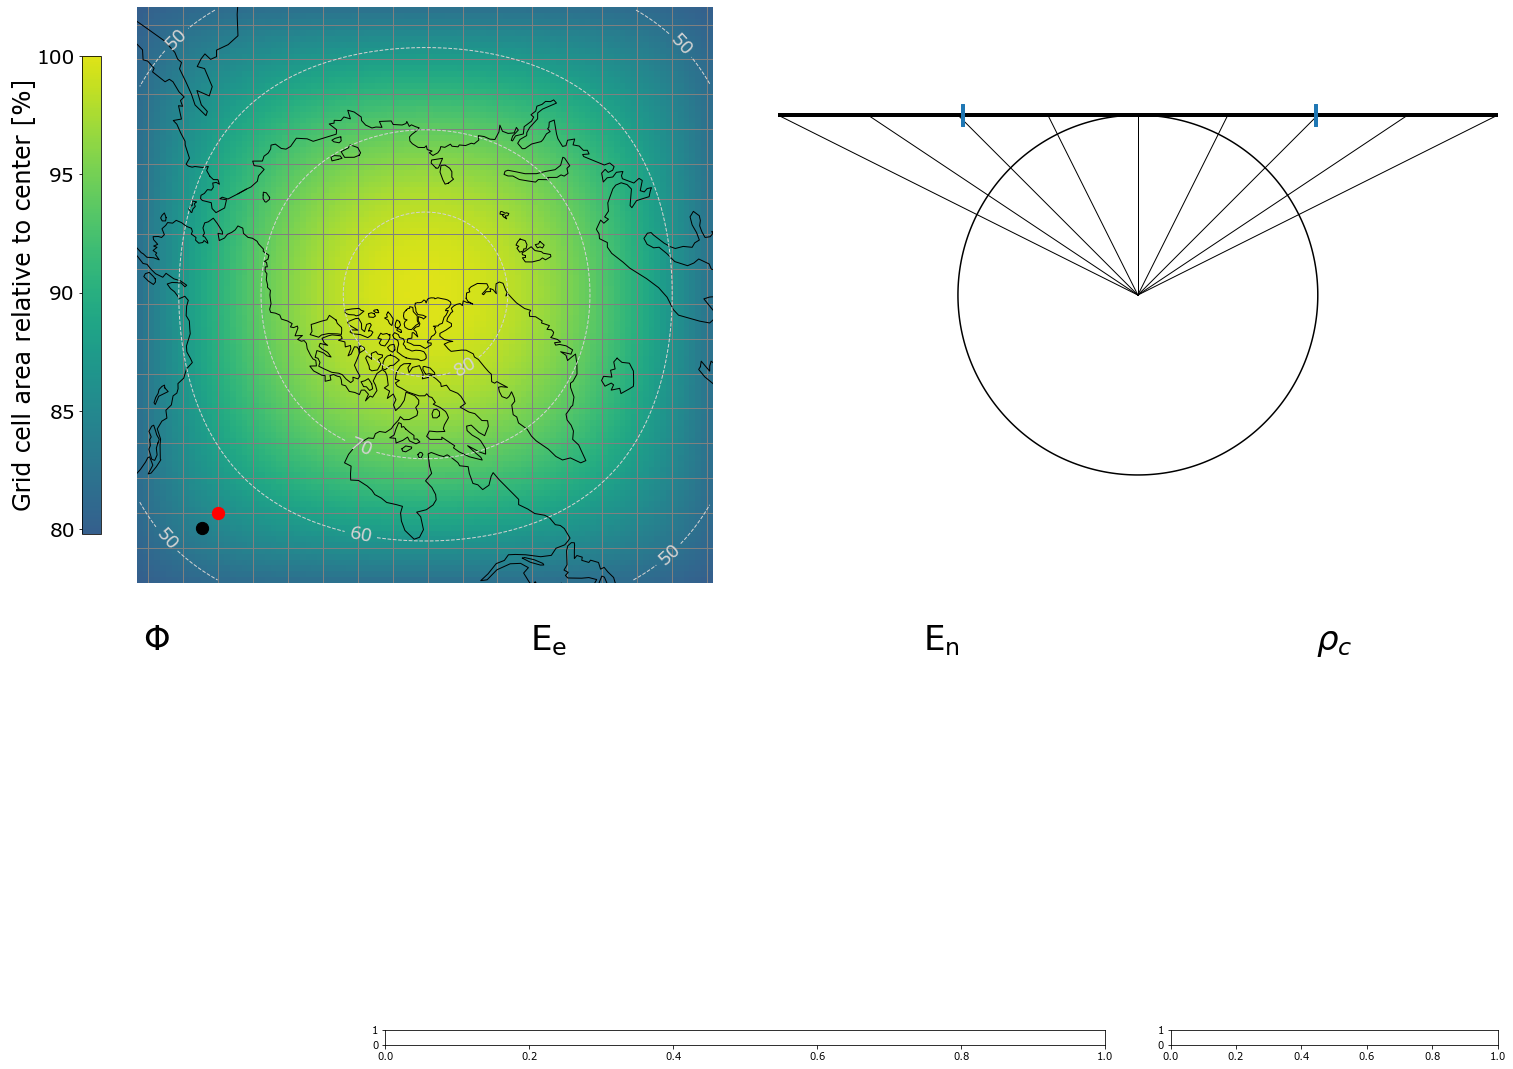

In [7]:
# Start by setting up figure and subplots:
fig = plt.figure(figsize = (22,16))
spec = fig.add_gridspec(4, 4, height_ratios=[6,.01,3,.15])
axs = {}

# upper row
axs['grid'     ] = fig.add_subplot(spec[0, 0:2])
axs['onsphere' ] = fig.add_subplot(spec[0, 2:4])

# lower row
axs['potential'] = fig.add_subplot(spec[2, 0  ])
axs['E_e'      ] = fig.add_subplot(spec[2, 1  ])
axs['E_n'      ] = fig.add_subplot(spec[2, 2  ])
axs['Ediv'     ] = fig.add_subplot(spec[2, -1 ])
axs['cbar1'    ] = fig.add_subplot(spec[3, 1:3])
axs['cbar2'    ] = fig.add_subplot(spec[3, -1 ])

# title axes
titleargs = {'fontsize':34, 'y':1.1}
axs['potential'].set_title(r'$\Phi$',                    **titleargs)
axs['E_e'      ].set_title(r'$\mathrm{E}_{\mathrm{e}}$', **titleargs)
axs['E_n'      ].set_title(r'$\mathrm{E}_{\mathrm{n}}$', **titleargs)
axs['Ediv'     ].set_title(r'$\rho_c$',                  **titleargs)

# adjust
fig.subplots_adjust(left=.03, right=.98, bottom=.08, top=.99)

for key in axs.keys():
    if key in ['cbar1', 'cbar2']:
        continue
    axs[key].set_axis_off()
    axs[key].set_aspect('equal')

    
    
##### A) cubed sphere grid with coastlines

# add coastlines
a = apexpy.Apex(refh=110) # for coord. conversion to get coastlines in magnetic
for cl in grid.projection.get_projected_coastlines(mag=True, apex=a, resolution='110m'):
    axs['grid'].plot(cl[0], cl[1], color='black', linewidth=1)

# plot some of the grid cells
count = -1
for xi, eta in grid.get_grid_boundaries(geocentric=False):
    count += 1
    if count%6 != 0:
        continue
    axs['grid'].plot(xi, eta, color='grey', lw=1, zorder=1)

# adjust axis
xlim, ylim = (grid.xi_mesh[0, 0], grid.xi_mesh[-1, -1]), (grid.eta_mesh[0, 0], grid.eta_mesh[-1, -1])
axs['grid'].set_ylim(ylim)
axs['grid'].set_xlim(xlim)

# shade under grid region for relative rea
cmapIn = plt.get_cmap('viridis')
new_cmap = LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=.3, b=.95),
                                             cmapIn(np.linspace(.3, .95, 100)))
ticks = np.linspace(.8, 1, 5)*100
areas = axs['grid'].pcolormesh(grid.xi, grid.eta, grid.A/grid.A.max()*100,cmap=new_cmap, zorder=0)

# color bar
cbar1 = fig.colorbar(areas, ax=axs['grid'], location='left', ticks=ticks, orientation='vertical', shrink=.8, 
                     aspect=25, pad=.05)
cbar1.ax.tick_params(labelsize=20)
cbar1.ax.set_ylabel('Grid cell area relative to center [%]', fontsize=24, labelpad=.2)

# add indication of grid cell center (red) and grid cell corner (black)
axs['grid'].scatter(grid.xi_mesh[12,14], grid.eta_mesh[12,14], c='red', s=150)
axs['grid'].scatter(-0.4735, grid.eta[9,11], c='black', s=150)

# add latitude contours
latargs = {'linestyles':'--', 'linewidths':1, 'levels':np.r_[-80:81:10], 'zorder':2}
co = axs['grid'].contour(grid.xi, grid.eta, grid.lat, colors='lightgrey', **latargs)
axs['grid'].clabel(co, co.levels, inline=True, fontsize=18)



#### B) example of cube face intersecting sphere 

# cross section of cube face that is intersecting a sphere
xs = np.linspace(-4,4,1000)
ys = np.linspace(-4,4,1000)
a, b = np.meshgrid(xs, ys)
C = a ** 2 + b ** 2 - 16   # function of a circle with radius 4
axs['onsphere'].contour(a, b, C, levels=[0], colors='black')
axs['onsphere'].plot([-8,8],[4,4], color='black', lw=4)

# lines from center of sphere to equally spaced regions on grid
for i in range(-8,9,2):
    axs['onsphere'].plot([0,i],[0,4], color='black', lw=1)

# indicate grid region from (A) with blue lines
yedge = np.tan((90-grid.lat.min())*np.pi/180.)*4
axs['onsphere'].scatter([-yedge, yedge], [4, 4], c='C0', marker='$\mathrm{l}$', s=500, zorder=4)

# adjust
axs['onsphere'].set_xlim(-8,8)
axs['onsphere'].set_ylim(-6,6);

_*Lower row of panels*_

The Weimer model potential, the eastward elecric field, the northward electric field, and the charge density are plotted in the lower row of panels:

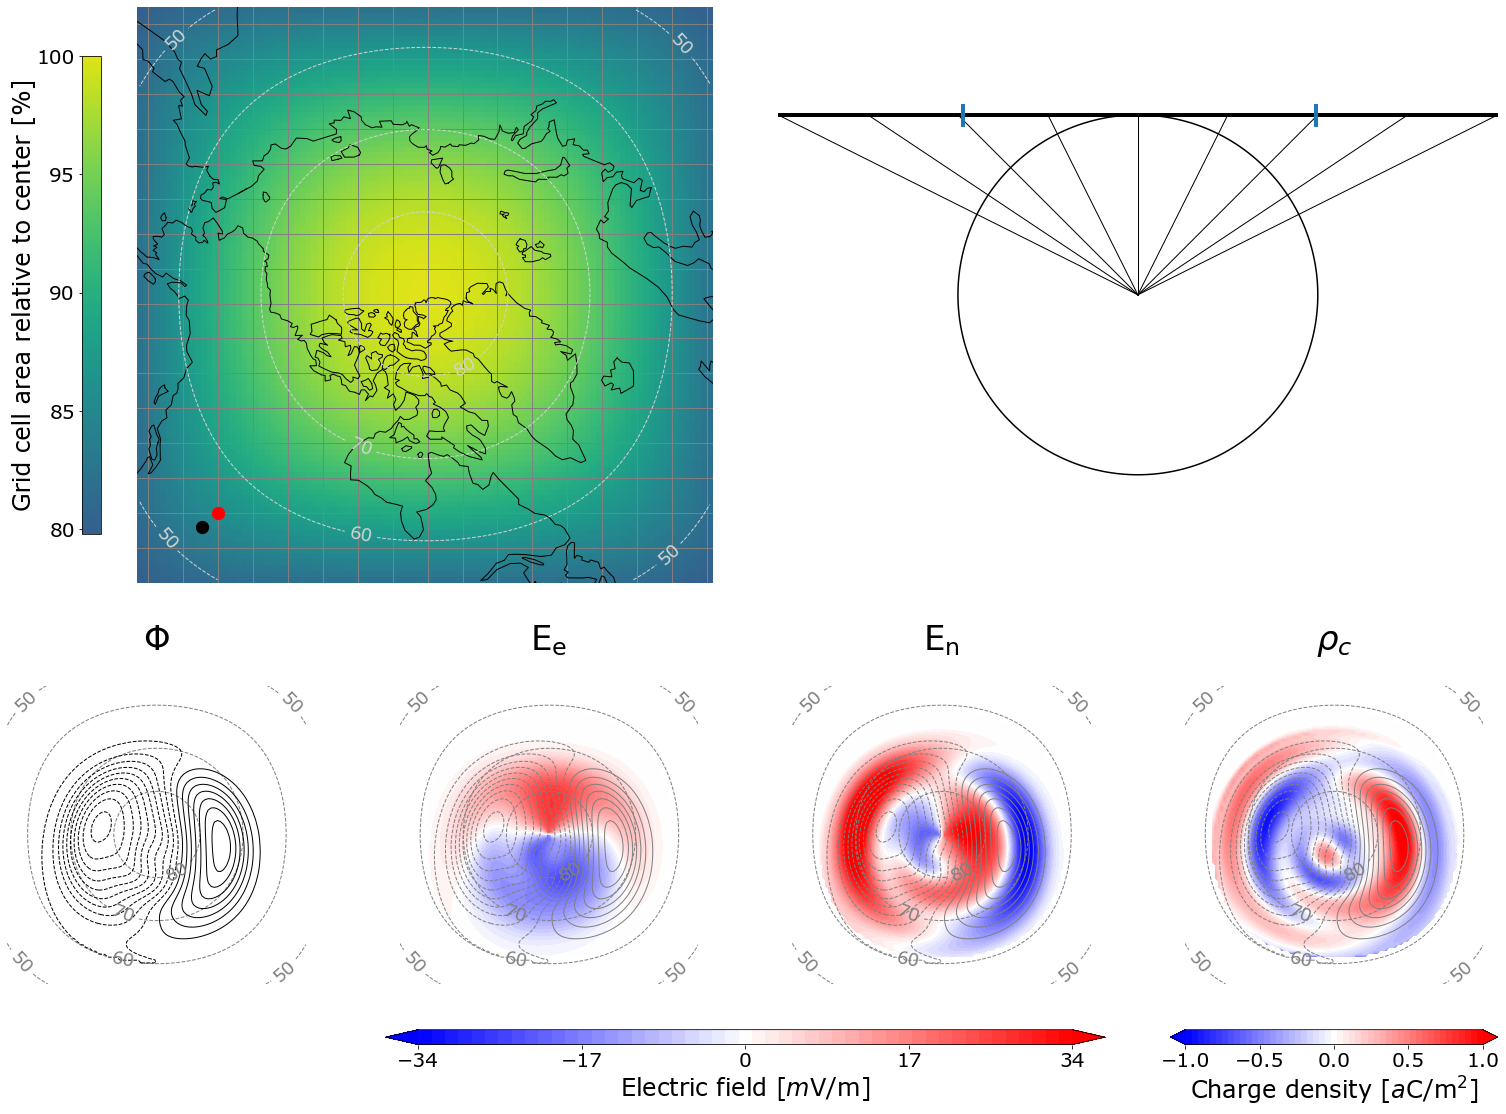

In [8]:
# Set up axes
for key in axs.keys():
    if key in ['grid','onsphere', 'cbar1', 'cbar2']: 
        continue
    # latitude contours
    c = axs[key].contour(grid.xi, grid.eta, grid.lat, colors='grey', **latargs)
    axs[key].clabel(c, c.levels, inline = True, fontsize = 18)

    
####### (C) Potential

potlevels = np.r_[-101:101:4]*1e3
axs['potential'].contour(grid.xi, grid.eta, Phi, colors='black', levels=potlevels, linewidths=1)

# add potential contours to plots (D)-(F)
axs['E_e'      ].contour(grid.xi, grid.eta, Phi, colors='gray',  levels=potlevels, linewidths=1)
axs['E_n'      ].contour(grid.xi, grid.eta, Phi, colors='gray',  levels=potlevels, linewidths=1)
axs['Ediv'     ].contour(grid.xi, grid.eta, Phi, colors='gray',  levels=potlevels, linewidths=1)


####### D) and E) - eastward, northward electric field

Elevels = np.linspace(-34,34,50)     # color scale for electric field components
Elevel_ticks = np.linspace(-34,34,5)

Eeastcont = axs['E_e'].contourf(grid.xi, grid.eta, E_e*1e3, levels=Elevels, cmap=plt.cm.bwr, extend='both')
axs['E_n'].contourf(            grid.xi, grid.eta, E_n*1e3, levels=Elevels, cmap=plt.cm.bwr, extend='both')

# color bar for E-field components
cbar2 = fig.colorbar(Eeastcont, cax=axs['cbar1'], ticks=Elevel_ticks, orientation='horizontal', shrink=.5, aspect=10)
cbar2.ax.tick_params(labelsize=20)
cbar2.ax.set_xlabel(r'Electric field [$m$V/m]', fontsize=24)


###### F) - charge density

divElevels = np.linspace(-1,1,50) # color scale for charge density (eps*divE)
divEticks  = np.linspace(-1,1,5) 

rho_c = axs['Ediv'].contourf(grid.xi, grid.eta, rho*1e18, levels=divElevels, cmap=plt.cm.bwr, extend='both')

# color bar for charge density
cbar3 = fig.colorbar(rho_c, cax=axs['cbar2'], ticks=divEticks, orientation='horizontal', shrink=.5)
cbar3.ax.tick_params(labelsize=20)
cbar3.ax.set_xlabel(r'Charge density [$a$C/m$^2$]', fontsize=24)

fig

Adjust figure and save

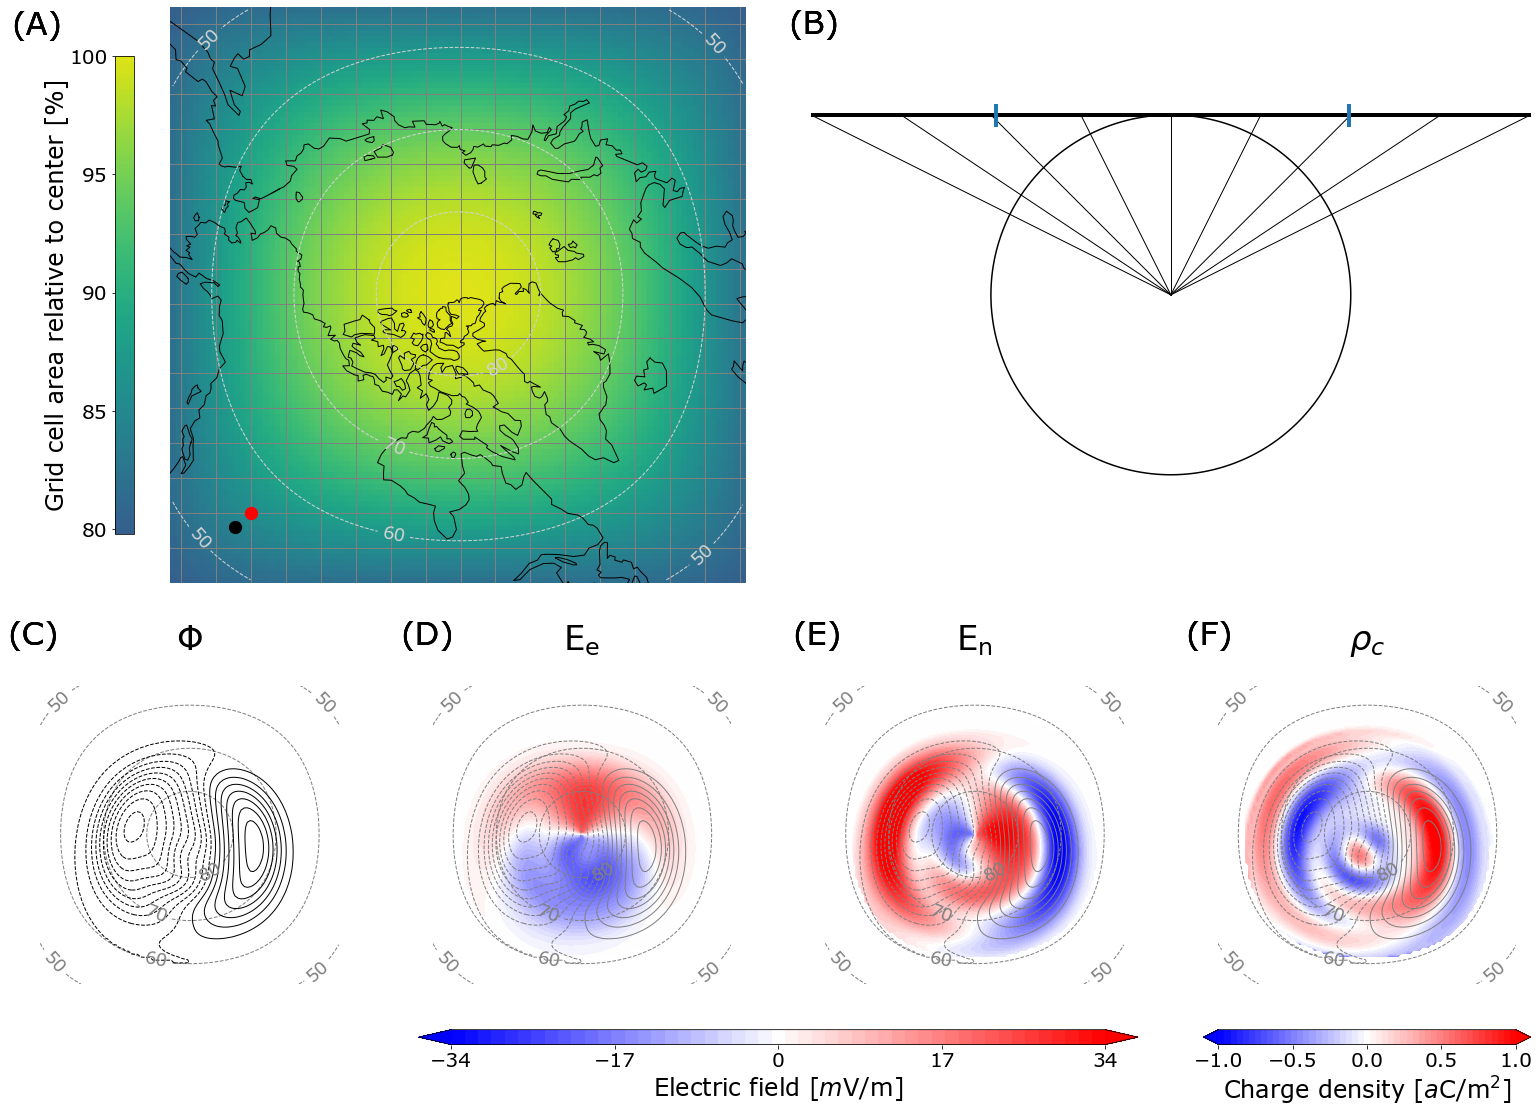

In [11]:
# add subfigure letters
fs=32
axs['grid'     ].text(-0.95, 0.55, '(A)', fontsize=fs)
axs['onsphere' ].text(-8.5,  5.8,  '(B)', fontsize=fs)
axs['potential'].text(-0.74, 0.77, '(C)', fontsize=fs)
axs['E_e'      ].text(-0.74, 0.77, '(D)', fontsize=fs)
axs['E_n'      ].text(-0.74, 0.77, '(E)', fontsize=fs)
axs['Ediv'     ].text(-0.74, 0.77, '(F)', fontsize=fs)

# save figure
fig.savefig('./output_figures/01CSexample.pdf')
fig.savefig('./output_figures/01CSexample.png')

fig

The parameters are plotted in cubed sphere $\xi, \eta$ coordinates. Note that the center of the grid is at the magnetic north pole.
    
- (A) Cubed sphere grid with coastlines (grey). The color contours shows that the area of the grid cells (projected on the sphere) decrease the further away from the center of the cube face they are. For illustration purposes, not all cells in the grid is shown. The red dot marks the center of a grid cell, and the black dot marks a corner of the same grid cell.

- (B) A cross section of a cubed sphere cube face (bold black line) intersecting a sphere. Thinner black lines show that equally spaced regions on the cube face map to increasingly smaller regions on the shpere the further away from the intersecting point we get. The extent of the grid in (A) is shown by blue markers.
    
- (C) The electrostatic Weimer model potential as black contours.
    
- (D) The eastward electric field component (color contours) derived from the Weimer model potential (gray contours).
    
- (E) The northward electric field component (color contours) derived from the Weimer model potential (gray contours).

- (F) The charge density (color contours) derived from the Weimer model potential (gray contours).